# Introduction: Build an alternative occupation classification.

## Problem statement:
Construct a hierarchy of Jobs, using the available data

In order to create a hierarchy, jobs must be clustered together; given that there are no 'correct' labels, this is an unsupervised learning problem. Specifically, I am going to solve this problem with unsupervised clustering.

The first step is to investigate the data and use this to decide how I will cluster the data.

### Import data and libs

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer as CV
from scipy.cluster import hierarchy as clust
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import cdist

np.random.seed(42)

### Caution:
This may also need some NLTK downloads to work, I will assume you have them already

### Also:
I don't know the protcols for emailing IPython notebooks, so I have left the file paths as they are. Please change them to suit you obviously.

In [2]:
job_list = pd.read_csv('C:\\Users\\x\Documents\\Jobs\\NESTA\\occupations_en.csv')
skills_list = pd.read_csv('C:\\Users\\x\Documents\\Jobs\\NESTA\\skills_en.csv')
cross_tab =  pd.read_json('C:\\Users\\x\Documents\\Jobs\\NESTA\\ESCO_occup_skills.json')

### Basic data exploration:
Investigate what the data looks like and what shape it is; this was also done visually in excel.

In [3]:
print('Skill list shape is :', skills_list.shape, end = '\n\n')
print('Columns are:', skills_list.columns, end = '\n\n')
print('Column types')
for i in skills_list.columns:
	print(skills_list[i].dtype, i)


Skill list shape is : (13485, 7)

Columns are: Index(['conceptType', 'conceptUri', 'skillType', 'reuseLevel',
       'preferredLabel', 'altLabels', 'description'],
      dtype='object')

Column types
object conceptType
object conceptUri
object skillType
object reuseLevel
object preferredLabel
object altLabels
object description


In [4]:
print('Job list shape is:', job_list.shape, end = '\n\n')
print('Columns are:', job_list.columns, end = '\n\n')
print('Column types')
for i in job_list.columns:
	print(job_list[i].dtype, i)


Job list shape is: (2942, 6)

Columns are: Index(['conceptType', 'conceptUri', 'iscoGroup', 'preferredLabel', 'altLabels',
       'description'],
      dtype='object')

Column types
object conceptType
object conceptUri
int64 iscoGroup
object preferredLabel
object altLabels
object description


In [5]:
print('Cross table shape is:',cross_tab.shape, end = '\n\n')
print('Cross table indexes are:', cross_tab.index)

Cross table shape is: (15, 2942)

Cross table indexes are: Index(['className', 'classId', 'uri', 'title', 'referenceLanguage',
       'preferredLabel', 'alternativeLabel', 'preferredTerm',
       'alternativeTerms', 'description', 'status', '_links', '_embedded',
       'scopeNote', 'definition'],
      dtype='object')


### Actual clustering part
In order to form clusters with jobs, we need to decide on some features and a similarity measure. Some potential features come from:
- Job titles,
- Job description,
- Required skills.

If I choose Job title then all I can really say is that the jobs sound alike, which is unlikely to impact policy. 

Hence, I will use the Job description and the required skills

### Invesitigating Required Skills
I create an adjacency matrix $A$ (#skills X #jobs) such that


$$\begin{equation}
    A_{i,j}=
    \begin{cases}
      10, & \text{if Job}_j \text{  has Essential Skill}_j \\
      1, & \text{if Job}_j \text{  has Optional Skill}_j \\
      0, & \text{Else} \\
    \end{cases}
\end{equation}$$

This allows for easier inspection of the required skills and how they are distributed.

In [6]:
# Create each edge
## Input: list of skills, job and value of edge
## Output: edge and edge index
def to_edges(x, y, val):
	edge = np.zeros(skills_list.shape[0])
	non_zero = np.array([skills_list[skills_list['preferredLabel'] == z].index[0] for z in x])
	edge[non_zero]=val
	job_loc = job_list[job_list['preferredLabel'] == y].index[0]
	return edge, job_loc

# Create overall adjaceny matrix
## Input: Job and skill tables
## TODO: Speed up, use CountVectoriser
## Output: matrix
def create_matrix(job_list, skills_list):
	adj_matrix = np.zeros((job_list.shape[0], skills_list.shape[0]))
	for i in job_list['preferredLabel']:
		if 'hasEssentialSkill' in cross_tab[i]['_links']:
			x = cross_tab[i]['_links']['hasEssentialSkill']
			x = [z['title'] for z in x]
			edge, job_loc = to_edges(x, i, 10)
			adj_matrix[job_loc] += edge
		if 'hasOptionalSkill' in cross_tab[i]['_links']:
			x = cross_tab[i]['_links']['hasOptionalSkill']
			x = [z['title'] for z in x]
			edge, job_loc = to_edges(x, i, 1)
			adj_matrix[job_loc] += edge
	return adj_matrix

adj_matrix = create_matrix(job_list, skills_list)

Find the frequency of both skills and jobs

In [7]:
# Count how many skills each job has
numberOfEssentialSkills = np.sum(adj_matrix==10, 1)
numberOfOptionalSkills = np.sum(adj_matrix==1, 1)

# Number of jobs each skills used
numberOfEssentialJobs = np.sum(adj_matrix==10, 0)
numberOfOptionalJobs = np.sum(adj_matrix==1, 0)

Descibe the essential Jobs:

- Basic stats on skills
- Find the jobs with the least and most skills
- Plot histogram of skill distribution
- Plot freqency 
    

In [8]:
print(st.describe(numberOfEssentialSkills), end = '\n\n' )

# Print the jobs with the lowest number of required skills
lowest_10_jobs = adj_matrix[np.argsort(numberOfEssentialSkills)[:9]]
for i, j in enumerate(lowest_10_jobs):
	print(skills_list['preferredLabel'][j==10], end = '\n\n')
	print(job_list['preferredLabel'][np.argsort(numberOfEssentialSkills)[i]], end = '\n\n')

# Print the jobs with the highest number of required skills
highest_10_jobs = adj_matrix[np.argsort(-numberOfEssentialSkills)[:9]]
for i, j in enumerate(highest_10_jobs):
	print(skills_list['preferredLabel'][j==10], end = '\n\n')
	print(job_list['preferredLabel'][np.argsort(-numberOfEssentialSkills)[i]], end = '\n\n')




DescribeResult(nobs=2942, minmax=(0, 136), mean=20.45615227736234, variance=133.93738308187002, skewness=2.7231162139727263, kurtosis=11.876116063904101)

Series([], Name: preferredLabel, dtype: object)

specialist dentist

2958    provide healthcare services to patients in gen...
Name: preferredLabel, dtype: object

general practitioner

12137    provide healthcare services to patients in spe...
Name: preferredLabel, dtype: object

specialised doctor

7027    energy efficiency
Name: preferredLabel, dtype: object

energy consultant

832     comply with food safety and hygiene
4779               maintain linen operation
Name: preferredLabel, dtype: object

linen room attendant

4071            fishing gear
6292    pollution prevention
Name: preferredLabel, dtype: object

fishing net maker

289     load animals for transportation
758             control animal movement
7723              manage animal hygiene
Name: preferredLabel, dtype: object

catcher

483                         distin

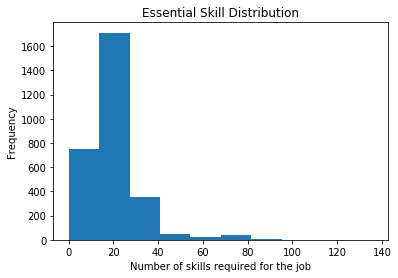

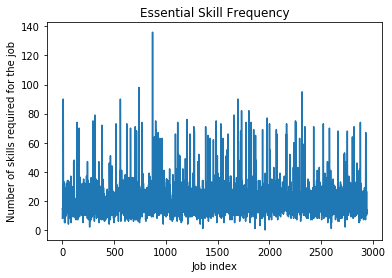

In [9]:
plt.hist(numberOfEssentialSkills)
plt.title('Essential Skill Distribution')
plt.xlabel('Number of skills required for the job')
plt.ylabel('Frequency')
plt.show()

plt.plot(numberOfEssentialSkills)
plt.title('Essential Skill Frequency')
plt.xlabel('Job index')
plt.ylabel('Number of skills required for the job')
plt.show()

This tells us that some of the skills are really specific whereas some are much more general, very akin to words.
And specialist dentist is likely a mistake as it has no essential skills, or it really easy to become a specialist dentist.

Descibe the essential skills:

- Basic stats on Jobs
- Find the skills with the least and most jobs
- Plot histogram of job distribution
- Plot frequency 

In [10]:
print(st.describe(numberOfEssentialJobs), end = '\n\n')

# describe the 10 least common skills and least in which jobs they occour
lowest_10_jobs = adj_matrix[:, np.argsort(numberOfEssentialJobs)[:9]]
for i, j in enumerate(lowest_10_jobs.T):
	print(job_list['preferredLabel'][j==10], end = '\n\n')
	print(skills_list['preferredLabel'][np.argsort(numberOfEssentialJobs)[i]], end = '\n\n')

# describe the 10 most common skills and least in whcih jobs they occour
highest_10_jobs = adj_matrix[:, np.argsort(-numberOfEssentialJobs)[:9]]
for i, j in enumerate(highest_10_jobs.T):
	print(job_list['preferredLabel'][j==10], end = '\n\n')
	print(skills_list['preferredLabel'][np.argsort(-numberOfEssentialJobs)[i]], end = '\n\n')


DescribeResult(nobs=13485, minmax=(0, 254), mean=4.462884686688914, variance=152.76376993367606, skewness=8.271104667909437, kurtosis=100.71513879072754)

Series([], Name: preferredLabel, dtype: object)

report unsafe behaviour

Series([], Name: preferredLabel, dtype: object)

manage construction archive

Series([], Name: preferredLabel, dtype: object)

provide individual exercise programmes

Series([], Name: preferredLabel, dtype: object)

follow environmentally-sustainable work practices

Series([], Name: preferredLabel, dtype: object)

make architectural mock-ups

Series([], Name: preferredLabel, dtype: object)

perform pathology consultations

Series([], Name: preferredLabel, dtype: object)

shine shoes

Series([], Name: preferredLabel, dtype: object)

install scaffolding pump jacks

Series([], Name: preferredLabel, dtype: object)

motivate supporters

4                 hospitality revenue manager
12                       tobacco shop manager
14                              mine su

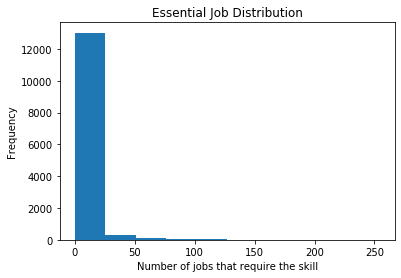

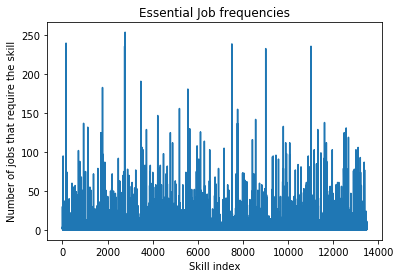

In [11]:
plt.hist(numberOfEssentialJobs)
plt.title('Essential Job Distribution')
plt.xlabel('Number of jobs that require the skill')
plt.ylabel('Frequency')
plt.show()

plt.plot(numberOfEssentialJobs)
plt.title('Essential Job frequencies')
plt.xlabel('Skill index')
plt.ylabel('Number of jobs that require the skill')
plt.show()


This tells us that some of the jobs require lots of skills whereas most requires only a few specific ones. There are also a bunch of skills that are not actually in the data set. In general, I can leave these as they won't really impact the data, although I could also remove them.

The frequency plots are very similar to what we would see in an NLP problem, with each skill representing a word and each job a sentence.

As such is makes sense to treat this as a NLP problem, with the Adjacency matrix being equivalent to a bag of words representation. Because of this I can now undertake some pre-processing which is NLP specific, TF_IDF transformation, which decreases the weights of 'popular skills' and prioritises the more specific ones.

In [12]:
# TFIDF transforms the BOW so  popular 'words' (skills) are unweighted
trans = TfidfTransformer()
tf_idf_matrix = trans.fit_transform(adj_matrix).toarray()

### Job description
This requires slightly less description because I already know that it is an NLP problem. 

First, I remove all punctuation, and transform all words into 'lemma' form, e.. transforming the words into their simplest format.

I then transform this into a Bag of Words, in essence creating a matrix very similar to the adjacency matrix.

$$\begin{equation}
    A_{i,j}=
    \begin{cases}
      1, & \text{if word}_i \text{  is in Job description}_j \\
      0, & \text{Else} \\
    \end{cases}
\end{equation}$$

This matrix can then be weighted via TF_IDF transformation, decreasing the weighting of the popular words and prioritising the more specific words. I also do this for job title.

In [13]:
# Create a joint lemma and count vectoriser
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tf_vectorizer = CV(tokenizer=LemmaTokenizer(), strip_accents = 'unicode', lowercase = True)
# Create a TD-IDF version of the Job description
job_description = trans.fit_transform(tf_vectorizer.fit_transform(job_list['description'])).toarray()
# Create a TD-IDF version of the Job titles
job_title = trans.fit_transform(tf_vectorizer.fit_transform(job_list['preferredLabel'])).toarray()

Finally I combine my two newly weighted matrices into one large feature group (Adjacency matrix and Job description).

In [14]:
features = np.hstack((job_description, tf_idf_matrix))

### Similarity Measure

Now that I have my feature matrix, which is a large binary matrix, I can begin to actually cluster stuff. My similarity measure, to determine how 'alike' two jobs are will be the Manhattan distance between the rows which correspond to the jobs (cdist).



### Actually clustery bit

As the goal is to form a hierarchy, the obvious clustering algorithm to use is agglomerative clustering. This clusters the data by joining the two most similar jobs/job cluster, until a given number of classes are reached.

At the moment the clustering always tries to break the data into sets of 10, if I have time this will instead be optimised over the silhouette score.


In [15]:
# Takes distance matrix and use agglomorative
# clustering to split into clusters
## Input: Distance between features, size of small data set that doesn't need to 
# be clustered
## TODO: Add code that tries other values of K, not just 10
## Output: Labels
def clusterer(dist_matrix, cutoff):
    # Don't bother clustering small data sets
	if dist_matrix.shape[0]<=cutoff:
		return np.repeat(['Z'],dist_matrix.shape[0])
	Z = linkage(dist_matrix, 'ward')
    
	labels_numeric = clust.fcluster(Z, 10, criterion='maxclust')
	return np.array([chr(64 + int(x)) for x in labels_numeric])



In [16]:
# With this I create blank codes in Label array. I then find all unique combinations of 'codes'
# and cluster these again until I reach a maximum of ten items per cluster (the cut off value in clusterer).

# Input: feature array, depth of classification
## TODO make code understanable by a human, this was orignially a recursive function that I made iterative, 
# I would have been better starting from scratch
# Output: Code representing the hierarchy

def hierarchy_cluster(data_tab, depth):
	label_array = np.zeros((data_tab.shape[0],depth+1), dtype=np.object)
	dist_matrix = cdist(data_tab, data_tab)
	label_array[:,0] = clusterer(dist_matrix, cutoff=9)

	for i in np.arange(1, depth):
		codes = np.apply_along_axis(lambda x: ''.join([str(y) for y in x]), 1, label_array)
		uniq = np.unique(codes)
		for j in uniq:
			if j.replace('0', '')[-1]!='Z' :
				new_labels = clusterer(dist_matrix[codes==j], cutoff=10)
				label_array[codes==j, i] = new_labels
	codes = np.apply_along_axis(lambda x: ''.join([str(y) for y in x]), 1, label_array)
	codes = [x.replace('0','X') for x in codes]
	return codes

labels = hierarchy_cluster(features, 9)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()


### Clean-up
In this part I do some quick clean-up on the data to ensure that the labels are of minimum length and that there are no singular clusters.


In [17]:
# cleanup long labels
max_depth = np.max([x.index('X') for x in labels])
trimmed_codes = np.array([x[:(max_depth)] for x in labels])

# For all singular clusters, move them upone level so that can are not alone
# Input: Codes and size of minimum cluster
# Output: Codes with no cluster smaller than minimum
def de_singular(codes, minimum):
	new_lab = np.copy(codes)
	for i, j in enumerate(codes):
		count = np.sum(codes==j)
		if count<minimum:
			new_lab[i] = j[:j.index('Z')-1]+'Z' + j[j.index('Z'):]
		else:
			new_lab[i] = j
	return new_lab

trimmed_codes = de_singular(trimmed_codes, 4)
    
# Create the actual table
job_list['codes'] = trimmed_codes
job_codes = job_list[['preferredLabel', 'codes']]
job_codes

,preferredLabel,codes
0,technical director,GEBZZXXXX
1,metal drawing machine operator,GHICZXXXX
2,precision device inspector,GGJEHZXXX
3,air traffic safety technician,GGFHIFZXX
4,hospitality revenue manager,GGFAEZXXX
...,...,...
2937,demographer,GGHEZZXXX
2938,sorter labourer,GGJHZZXXX
2939,armoured car guard,GGFHHZZXX
2940,civil service administrative officer,GGFHHZZXX


# Performance of clustering
Now that data has been clustered, the performance will be computed.  For each cluster, the average number of dissimilar words in each cluster can be computed, this gives a vague notion of success.

In [18]:
def solution_scorer(i):
	cv = CV()
	word_array = cv.fit_transform(i['preferredLabel']).toarray()
	return cdist(word_array, word_array).mean()



### Distribution of clusters:
As we can see, the average number of dissimilar words in the clusters is 1.7, with a min and max of 0.7-2.9. I believe this is reasonably good.

DescribeResult(nobs=368, minmax=(0.7071067811865476, 2.8511021970961608), mean=1.6640902468278405, variance=0.097114321228966, skewness=0.18446681395252323, kurtosis=0.7697308648251724)



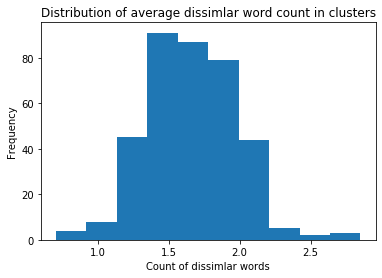

In [19]:
score = job_codes.groupby('codes').apply(solution_scorer).values

print(st.describe(score), end = '\n\n')
plt.hist(score)
plt.title('Distribution of average dissimlar word count in clusters')
plt.xlabel('Count of dissimlar words')
plt.ylabel('Frequency')
plt.show()

### Size of clusters:
As we can see, the size of a cluster is 8, with a min and max of 2 and 25 respectively. This again seems acceptable to me.

DescribeResult(nobs=368, minmax=(2, 25), mean=7.994565217391305, variance=19.024493543419027, skewness=1.260418554234742, kurtosis=1.091423129826251)



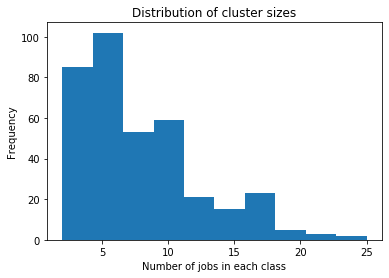

In [20]:
cluster_counts = job_codes.groupby('codes').count().values.flatten()

print(st.describe(cluster_counts), end = '\n\n')
plt.hist(cluster_counts)
plt.title('Distribution of cluster sizes')
plt.xlabel('Number of jobs in each class')
plt.ylabel('Frequency')
plt.show()

These are very simple metrics of success but they appear to work

# Conclusion
It seems that it is possible to cluster the jobs by making use of essential skills, optional skills and the job descriptions. The job title differences in the clusters are relatively small, suggesting that the clustering is a success. Obviously future work needs to be put into the finding optimal weighting for the essential skills, optional skills and the descriptions. Additionally, it may be prudent to use differing values of K when clustering, not just 10.